In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

import ultraplot as uplt  # noqa: E402, I001

## Fit the Data

In [ ]:
from des_y6_imsim_analysis import bump, interpolant
from des_y6_imsim_analysis.utils import read_data

data = read_data("../../data/N_gamma_alpha_v2_statistical.hdf5")

model_module = interpolant

if model_module is bump:
    kwargs = {
        "num_pts": 10,
        "fixed_param_values": {
            "w": 0.025, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0,
        },
    }
else:
    kwargs = {"num_pts": 10, "model_kind": "G", "fixed_param_values": {}}

model_data = model_module.make_model_data(
    z=data.z,
    nzs=data.nzs,
    mn=data.mn,
    cov=data.cov,
    mn_pars=data.mn_pars,
    zbins=data.zbins,
    **kwargs,
)

In [42]:
from des_y6_imsim_analysis.stats import measure_map

map_params = measure_map(
    model_module=model_module,
    model_data=model_data,
    seed=23141,
    progress_bar=True,
    num_steps=50_000,
    learning_rate=1e-3,
)

100%|██████████| 50000/50000 [00:26<00:00, 1903.21it/s, init loss: 28870419945.5231, avg. loss [47501-50000]: -128.5705]  


In [43]:
import pprint

from des_y6_imsim_analysis.stats import compute_model_chi2_info

chi2_info = compute_model_chi2_info(
    model_module=model_module,
    model_data=model_data,
    data=data,
    params=map_params,
)

print("chi2:", chi2_info['chi2'])
print("dof:", chi2_info['dof'])
print("p-value:", chi2_info['p_value'])
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (chi2_info['model_mn'][:4] - 1).tolist(),
    (data.mn[:4] - 1).tolist(),
    (np.sqrt(np.diag(data.cov)[:4])).tolist(),
))
print("map params:\n", pprint.pformat(map_params))

chi2: 32.340736788109496
dof: 8
p-value: 8.091937905179997e-05
m vals:
    model: [-0.006076620761838458, 0.0171097152679911, 0.015011008332581843, 0.007600530041290687]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.0047024602830035055, 0.006288896649842293, 0.005567192029975384, 0.009586029597377903]
map params:
 {'a0_b0': Array(-0.0067857, dtype=float64),
 'a0_b1': Array(-0.00022796, dtype=float64),
 'a0_b2': Array(-0.00095348, dtype=float64),
 'a0_b3': Array(-0.00142363, dtype=float64),
 'a1_b0': Array(0.00797247, dtype=float64),
 'a1_b1': Array(0.00490925, dtype=float64),
 'a1_b2': Array(-0.00240525, dtype=float64),
 'a1_b3': Array(0.00183818, dtype=float64),
 'a2_b0': Array(-0.00286568, dtype=float64),
 'a2_b1': Array(-0.00091753, dtype=float64),
 'a2_b2': Array(0.00733487, dtype=float64),
 'a2_b3': Array(0.00257414, dtype=float64),
 'a3_b0': Array(0.00027078, dtype=float64),
 'a3_b1': Array(0.00021756, dtype=float

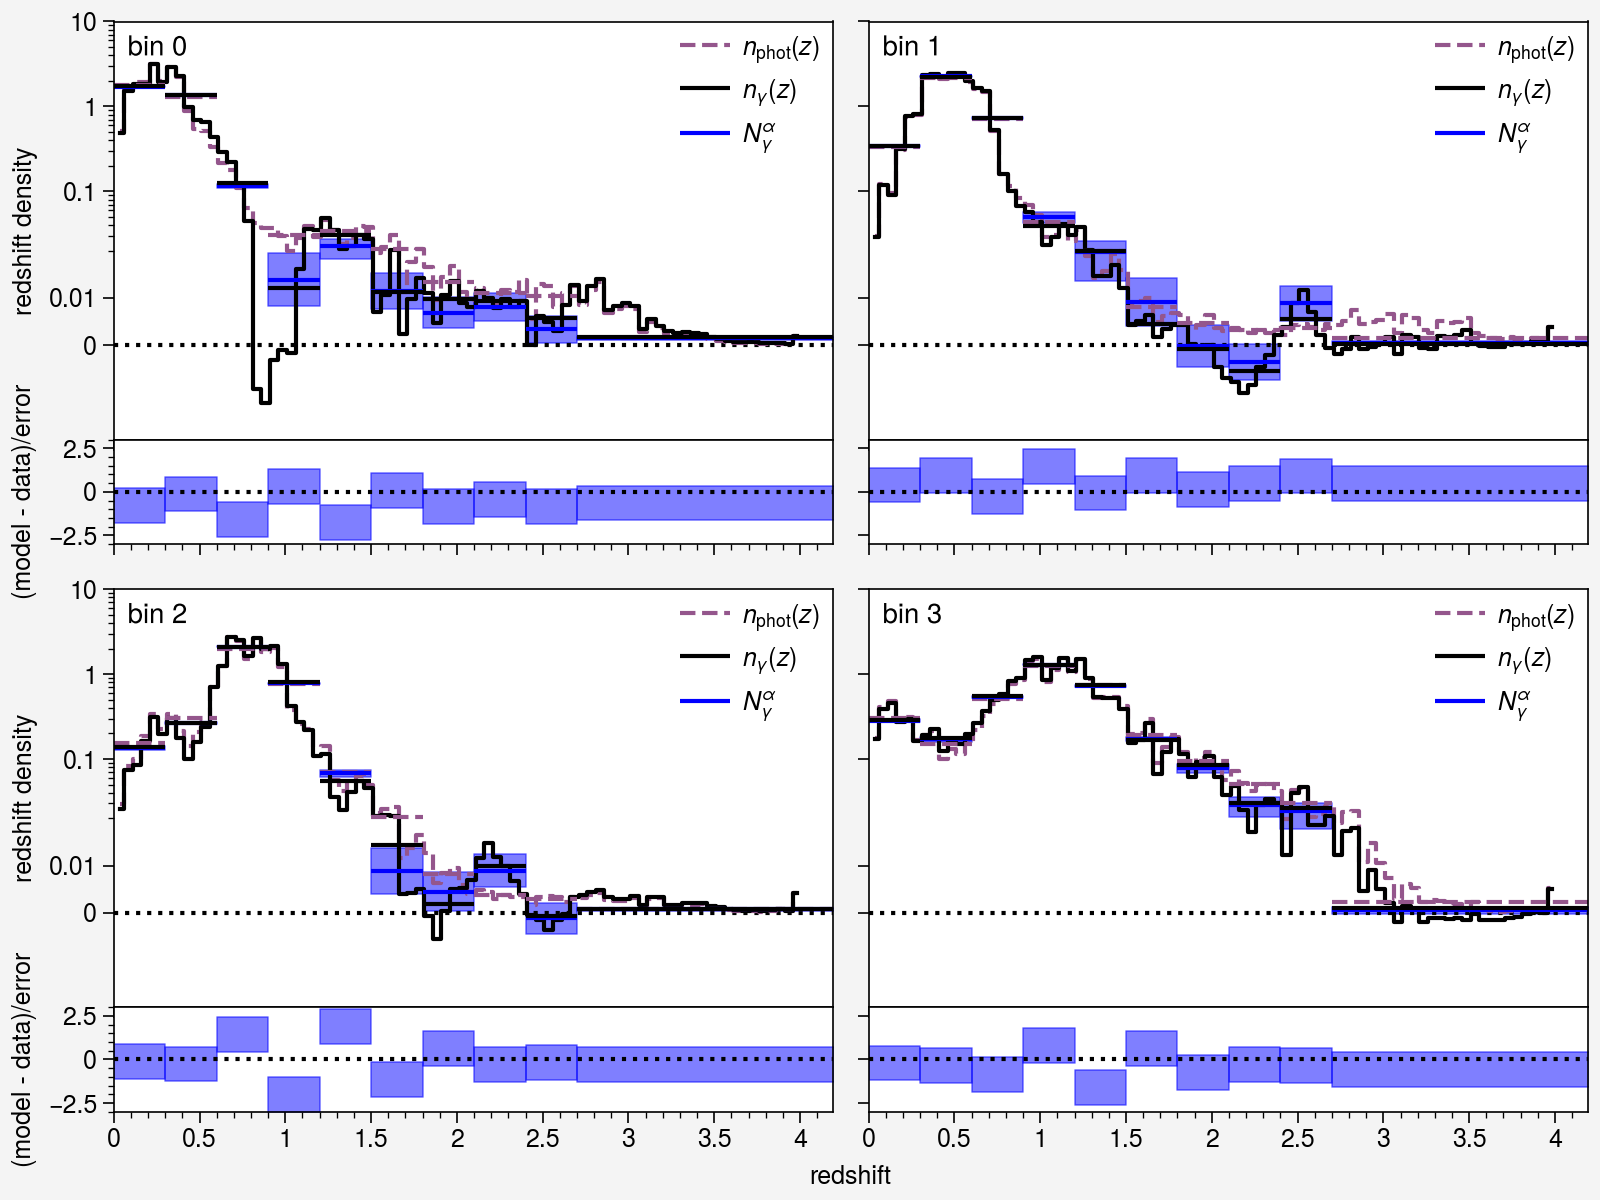

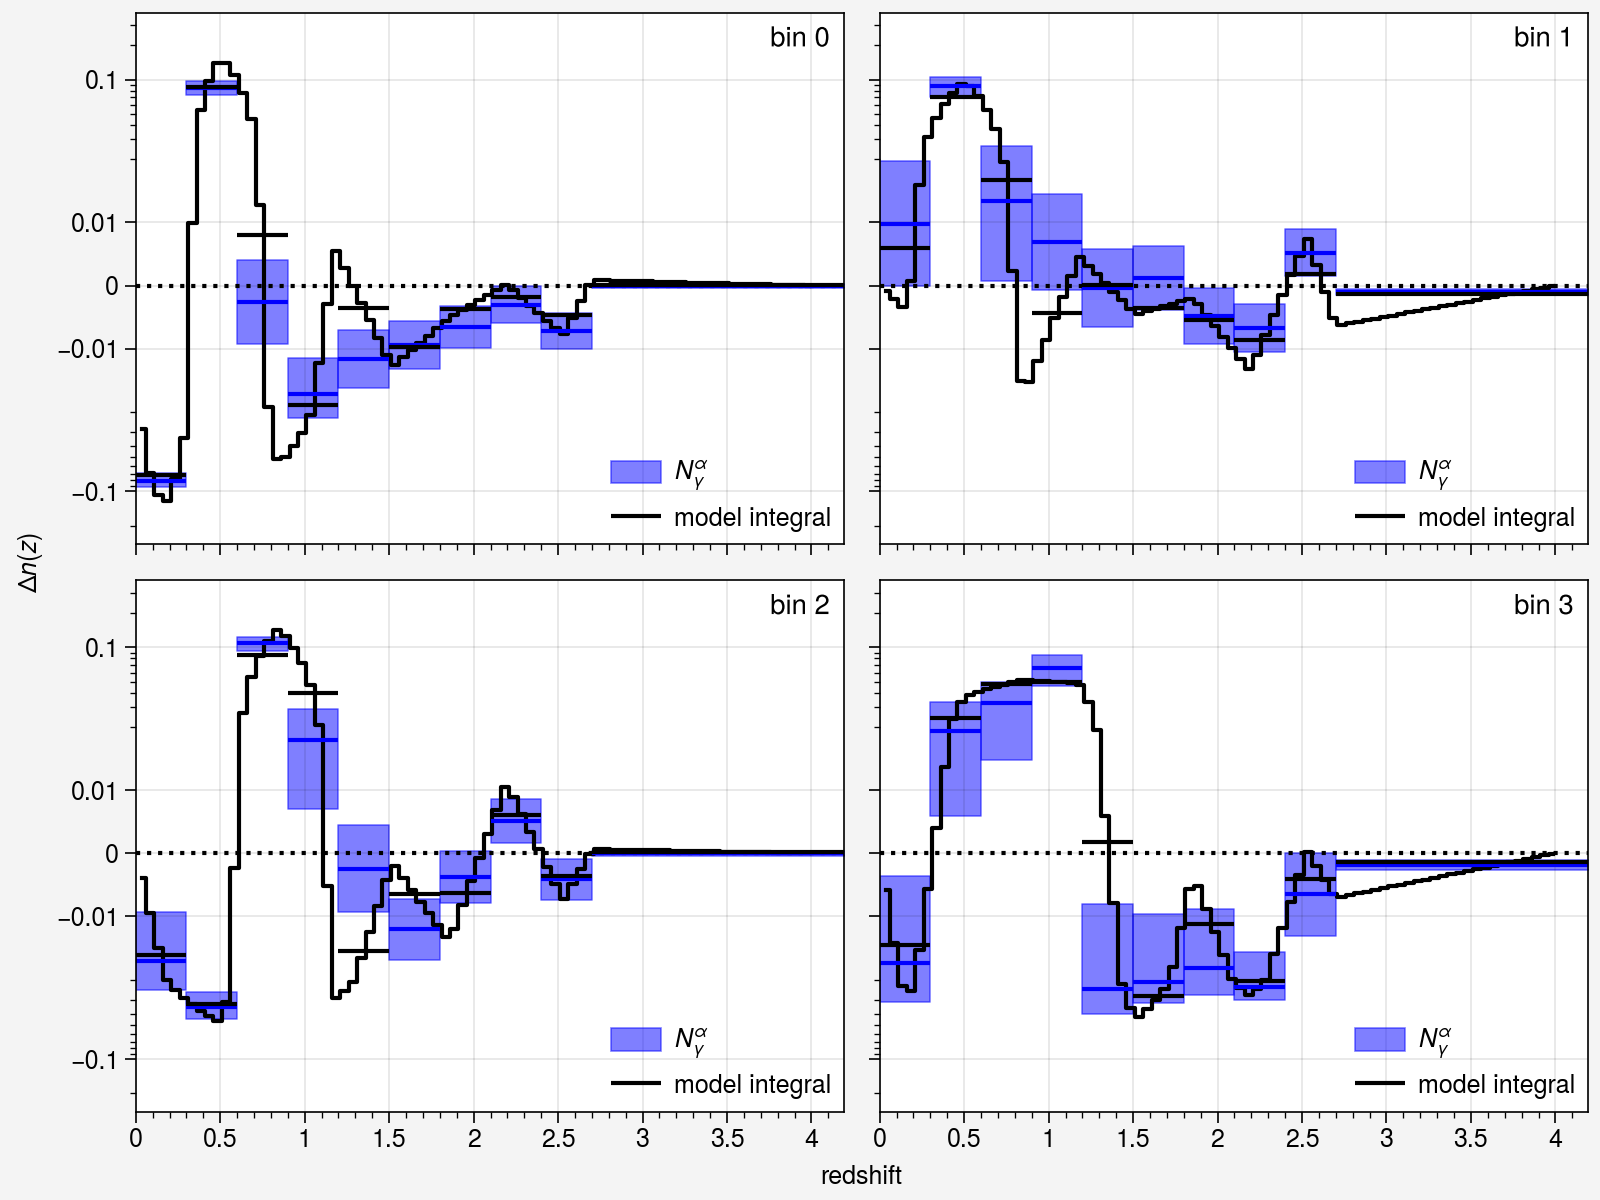

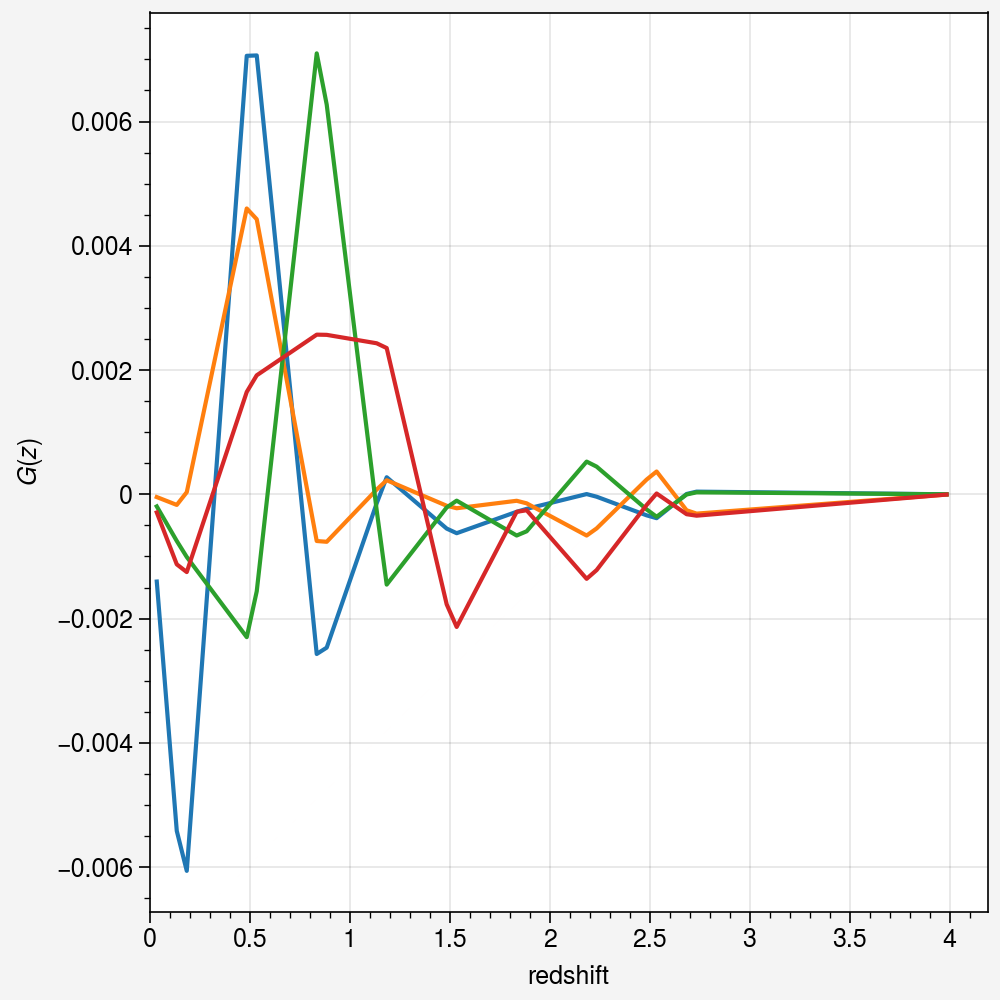

In [25]:
from des_y6_imsim_analysis.utils import (
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_symlog_nz,
)

fig = plot_results_symlog_nz(model_module=model_module, model_data=model_data, map_params=map_params)
fig = plot_results_delta_nz(model_module=model_module, model_data=model_data, map_params=map_params)
fig = plot_results_fg_model(model_module=model_module, model_data=model_data, map_params=map_params)

In [26]:
from des_y6_imsim_analysis.stats import run_mcmc

mcmc = run_mcmc(
    model_module=model_module,
    model_data=model_data,
    init_params=map_params,
    seed=231,
    progress_bar=True,
    dense_mass=True,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [27]:
mcmc.print_summary(exclude_deterministic=False)
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.01      0.00     -0.01     -0.01     -0.01   3319.23      1.00
     a0_b1     -0.00      0.00     -0.00     -0.00      0.00   4229.75      1.00
     a0_b2     -0.00      0.00     -0.00     -0.00     -0.00   4974.48      1.00
     a0_b3     -0.00      0.00     -0.00     -0.00      0.00   2617.78      1.00
     a1_b0      0.01      0.00      0.01      0.01      0.01   3634.67      1.00
     a1_b1      0.00      0.00      0.00      0.00      0.01   2438.55      1.00
     a1_b2     -0.00      0.00     -0.00     -0.00     -0.00   4410.50      1.00
     a1_b3      0.00      0.00      0.00      0.00      0.00   2330.45      1.00
     a2_b0     -0.00      0.00     -0.00     -0.00     -0.00   4266.96      1.00
     a2_b1     -0.00      0.00     -0.00     -0.00      0.00   3590.08      1.00
     a2_b2      0.01      0.00      0.01      0.01      0.01   3144.19      1.00
     a2_b3      0.00      0

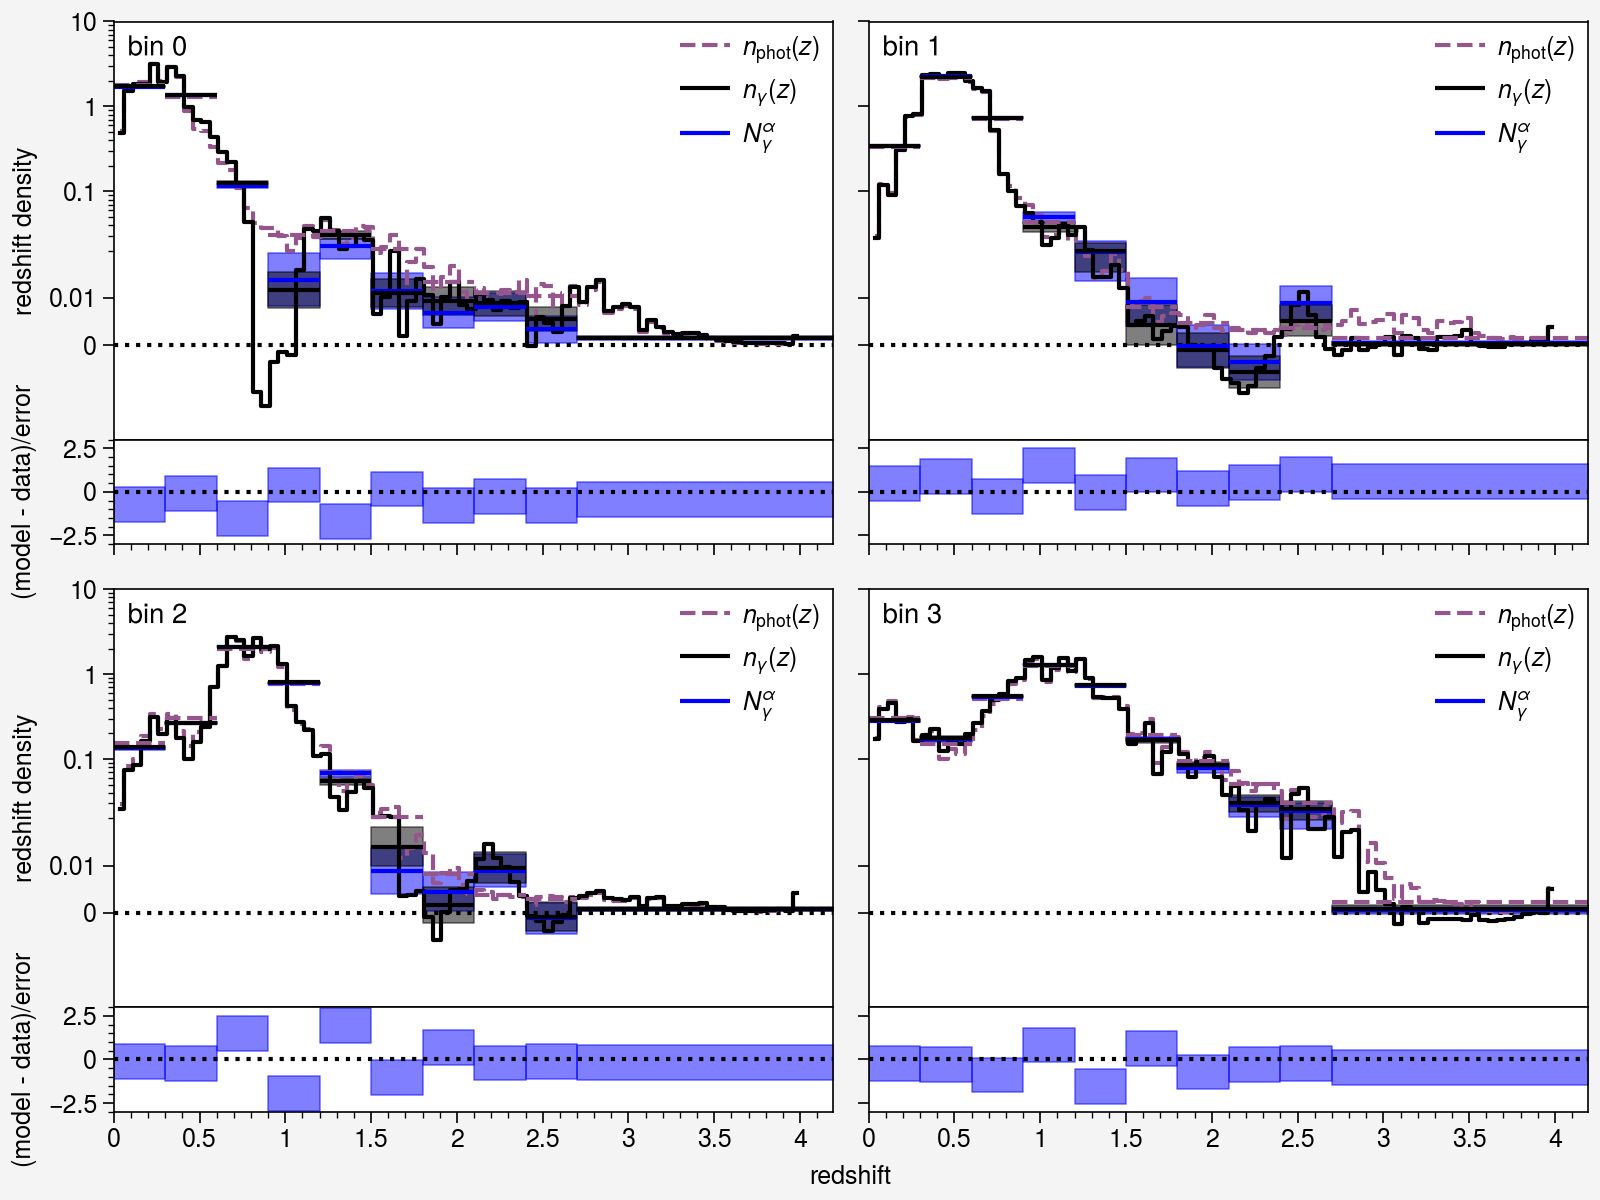

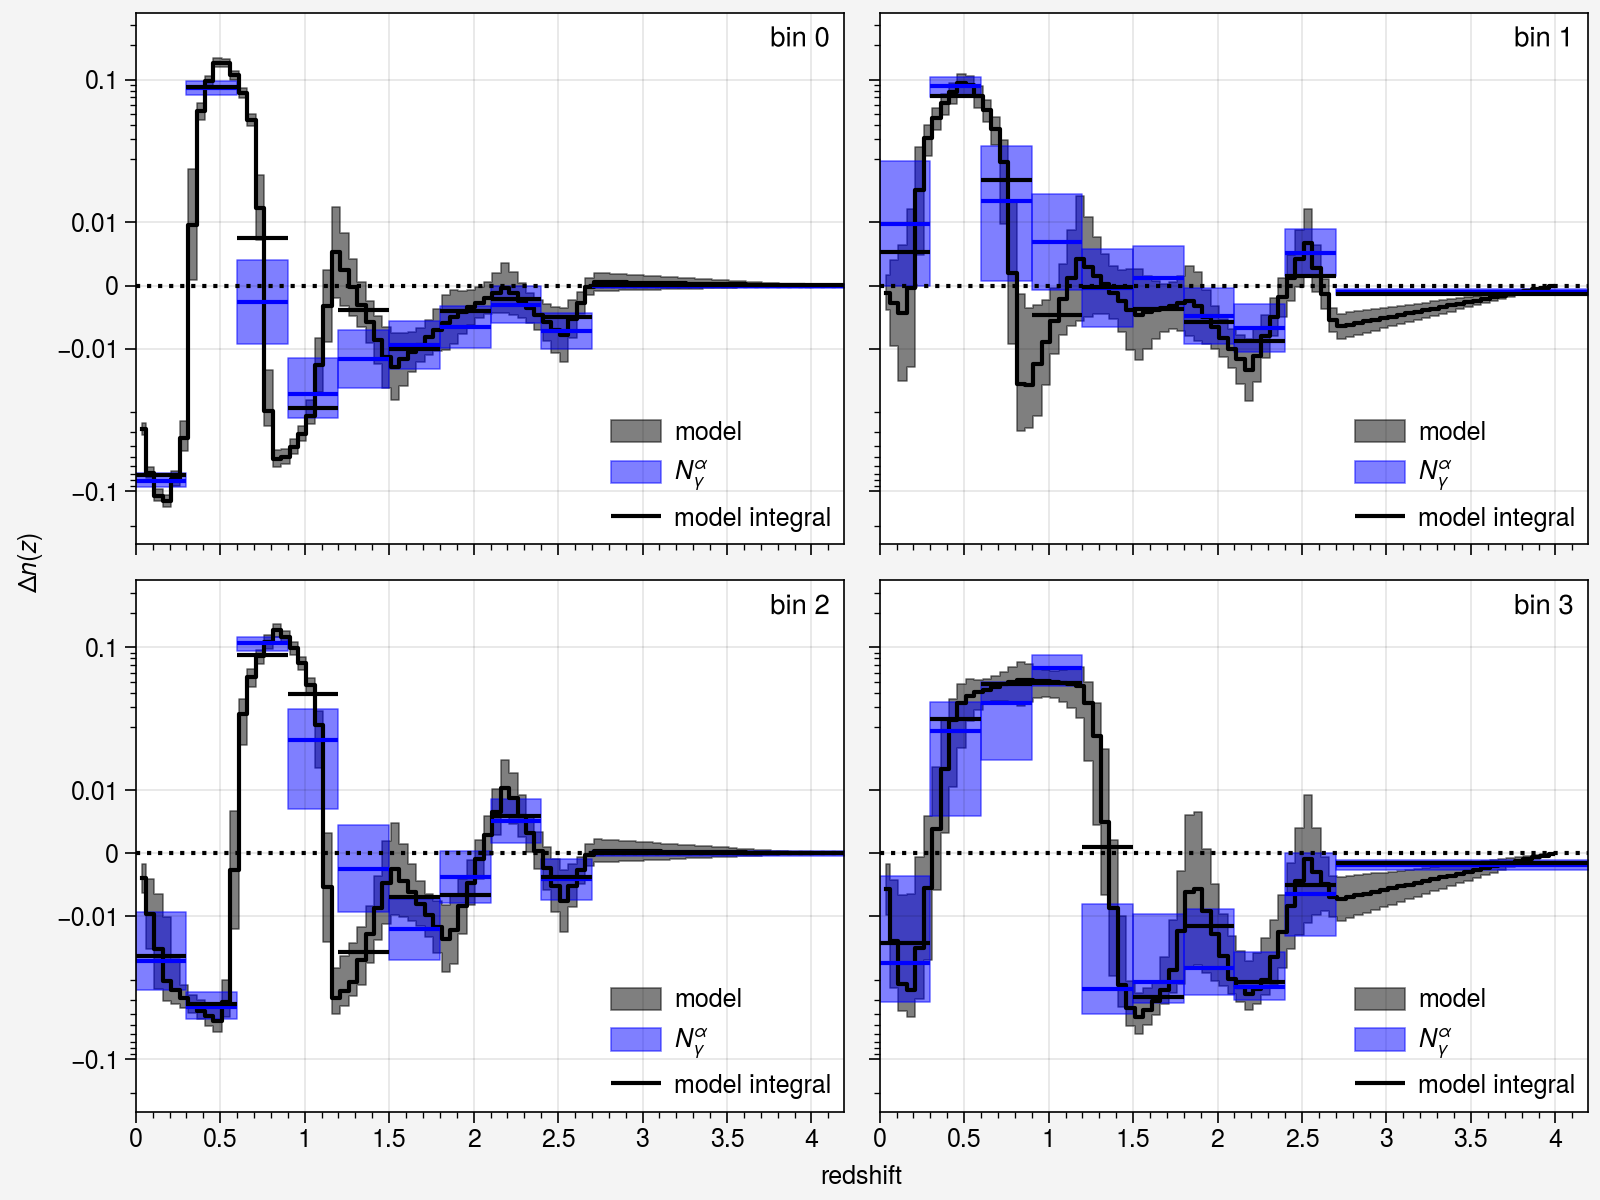

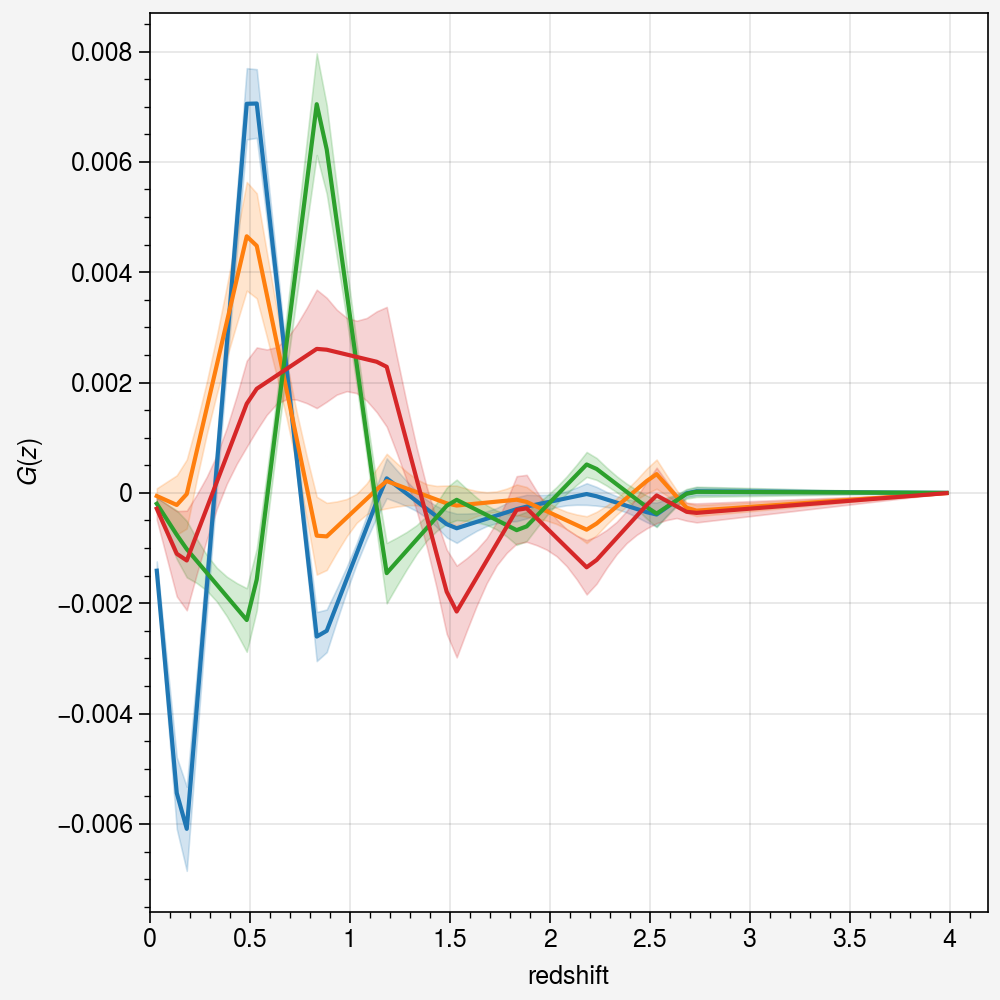

In [28]:
from des_y6_imsim_analysis.utils import (
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_symlog_nz,
)

fig = plot_results_symlog_nz(model_module=model_module, model_data=model_data, samples=samples)
fig = plot_results_delta_nz(model_module=model_module, model_data=model_data, samples=samples)
fig = plot_results_fg_model(model_module=model_module, model_data=model_data, samples=samples)

In [29]:
from des_y6_imsim_analysis.utils import measure_m_dz

mdz = measure_m_dz(
    model_module=model_module,
    model_data=model_data,
    samples=samples,
    return_dict=True,
)

In [30]:
m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -6.2 +/- 13.6    | -0.007 +/- 0.004 |
| 1   | +17.4 +/- 18.3    | -0.020 +/- 0.006 |
| 2   | +14.9 +/- 16.2    | +0.003 +/- 0.005 |
| 3   |  +7.5 +/- 27.1    | -0.032 +/- 0.009 |
|--------------------------------------------|


mdz_arr shape: (1000, 8)
(8, 8)


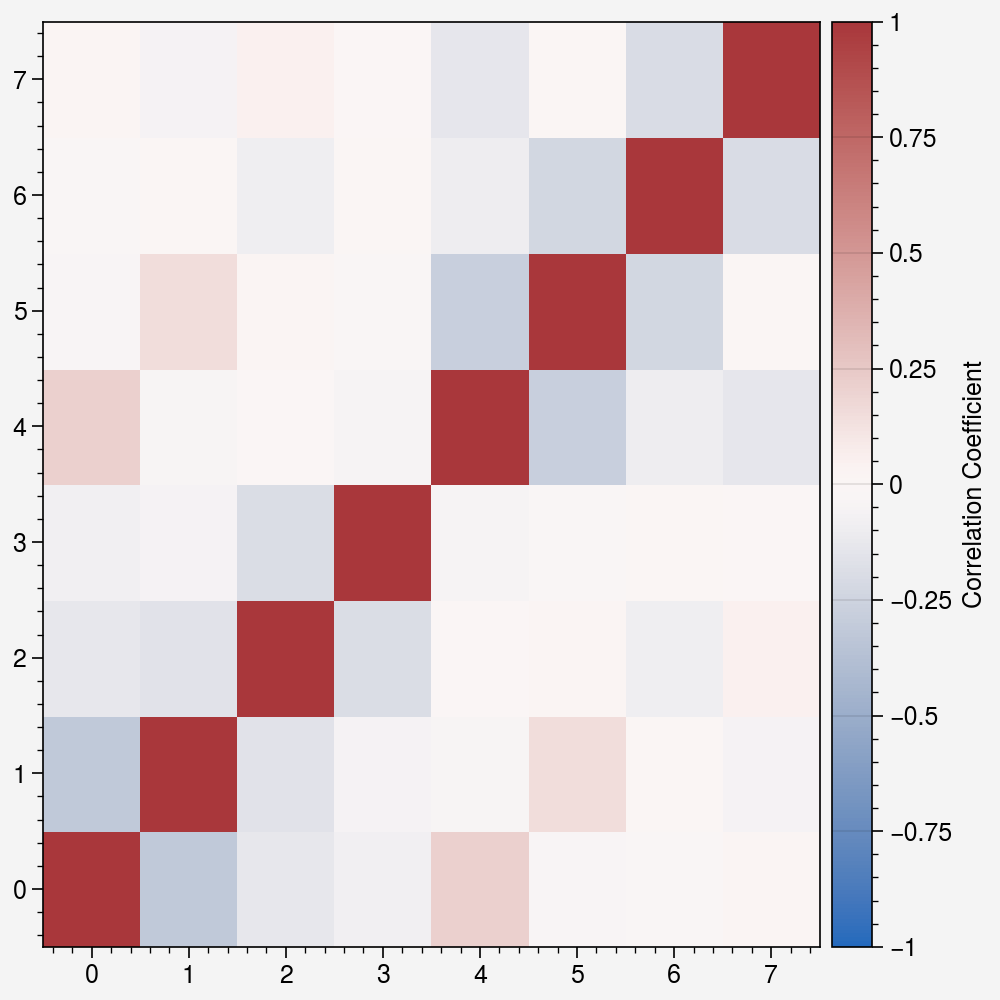

In [31]:
mdz_arr = np.vstack(
    [mdz[f"m_b{i}"] for i in range(4)]
    + [mdz[f"dz_b{i}"] for i in range(4)],
).T
print("mdz_arr shape:", mdz_arr.shape)

corr = np.corrcoef(mdz_arr.T)
print(corr.shape)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)

In [32]:
import corner
from matplotlib import pyplot as plt


if "g_b0" in samples and np.std(samples["g_b0"] > 0):
    # def softlaplace(x, loc=0, scale=1):
    #     z = (x - loc) / scale
    #     return 2.0 * np.pi / scale / (np.exp(z) + np.exp(-z))

    total = []
    for k in map_params.keys():
        if k == "w" or k.startswith("a"):
            continue
        total.append(samples[k].flatten())
    nd = len(total)
    total = np.array(total).T

    kwargs = {"alpha": 0.25}

    fig, axs = plt.subplots(nrows=nd, ncols=nd, figsize=(6, 6))
    corner.corner(total, fig=fig, plot_datapoints=False, plot_density=False);

    # for i in range(nd):
    #     ax = axs[i, i]
    #     x = np.linspace(
    #         -1, 1, 10000,
    #     )
    #     ax.plot(x, softlaplace(x, loc=0, scale=2.0 / np.pi) * 0.01 * samples[k].shape[0], color="blue")

# Compute Global `m`

```text
g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37687408.52750142 	 31852021.778152555
1 	 32262590.501660284 	 25166769.445796162
2 	 36321284.070149 	 28019787.27996662
3 	 22979366.319672316 	 14517510.901062118

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36935272.88896909 	 31258164.71036748
1 	 33630265.55123577 	 26647800.06951995
2 	 37616957.073409796 	 29500162.15844555
3 	 23442093.917962722 	 15133209.390449103

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38270056.368683755 	 32061262.610645365
1 	 35022342.94013908 	 27517630.555414688
2 	 30616116.814313516 	 23831877.593959697
3 	 25344050.202425964 	 15939348.02708475

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38219183.82005287 	 32044282.53917939
1 	 36907118.418624476 	 29395545.456652362
2 	 32107396.97912129 	 25375065.53263439
3 	 25919483.487100307 	 16645228.651692027
```

```text
g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37696158.10920723 	 31859661.180748507
1 	 32259102.894843798 	 25155195.522437155
2 	 36282302.28742035 	 27996436.095791794
3 	 22967280.29315682 	 14512115.373971423

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36954697.71678651 	 31274221.69176092
1 	 33637242.79052155 	 26646784.842271894
2 	 37562106.32644655 	 29462366.38122275
3 	 23429612.937475078 	 15128295.287524771

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38274918.97872326 	 32064819.320034783
1 	 35019489.74908048 	 27508553.10837389
2 	 30578214.610265676 	 23808678.22404237
3 	 25330304.019322462 	 15934145.88475994

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38234907.85639983 	 32057085.540191032
1 	 36914158.73922929 	 29396595.511817906
2 	 32053716.225799788 	 25337880.192668986
3 	 25903390.07112428 	 16639630.579854514
```

In [33]:
wR_plus = np.array([
    31852021.778152555,
    25166769.445796162,
    28019787.27996662,
    14517510.901062118,
])
wR_minus = np.array([
    31859661.180748507,
    25155195.522437155,
    27996436.095791794,
    14512115.373971423,
])

wR = (wR_plus + wR_minus)
wR /= np.sum(wR)

w_plus = np.array([
    37687408.52750142,
    32262590.501660284,
    36321284.070149,
    22979366.319672316,
])

w_minus = np.array([
    36935272.88896909,
    33630265.55123577,
    37616957.073409796,
    23442093.917962722,
])
w = (w_plus + w_minus)
w /= np.sum(w)
print("wR:", wR)
print("w:", w)

wR: [0.32003136 0.25277322 0.28137615 0.14581927]
w: [0.28604739 0.25258379 0.28342376 0.17794506]


In [34]:
m = np.sum([mdz[f"m_b{i}"] * wR[i] for i in range(4)], axis=0)

print(
    "global m: %+5.1f +/- %-5.1f" % (
        np.mean(m) / 1e-3,
        np.std(m) / 1e-3 * 3,
    )
)

global m:  +7.7 +/- 6.3  


## Apply to the Data

In [35]:
desnz_with_wz = np.load("../../data/Tz_realizations_WZ_bq_pile4_0d05.npy")

In [36]:
from des_y6_imsim_analysis.utils import compute_eff_nz_from_data

mvals, dzvals, finalnzs = compute_eff_nz_from_data(
    model_module=model_module,
    mcmc_samples=samples,
    model_data=model_data,
    input_nz=desnz_with_wz,
    rng=np.random.default_rng(45342),
    clip_zero=False,
)

mvals_nn, dzvals_nn, _ = compute_eff_nz_from_data(
    model_module=model_module,
    mcmc_samples=samples,
    model_data=model_data,
    input_nz=desnz_with_wz,
    rng=np.random.default_rng(45342),
    clip_zero=True,
)

In [37]:
if not np.all(finalnzs >= 0):
    print(f"Some of the n(s)s are negative! fraction = {np.mean(finalnzs < 0)}")

Some of the n(s)s are negative! fraction = 0.1390409856364537


In [38]:
m_mn = np.mean(mvals, axis=0)
m_sd = np.std(mvals, axis=0)

dz_mn = np.mean(dzvals, axis=0)
dz_sd = np.std(dzvals, axis=0)

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -6.2 +/- 13.7    | -0.006 +/- 0.004 |
| 1   | +17.3 +/- 18.3    | -0.021 +/- 0.006 |
| 2   | +15.1 +/- 16.1    | +0.002 +/- 0.005 |
| 3   |  +7.6 +/- 27.4    | -0.033 +/- 0.009 |
|--------------------------------------------|


In [39]:
m_mn = np.mean(mvals_nn, axis=0)
m_sd = np.std(mvals_nn, axis=0)

dz_mn = np.mean(dzvals_nn, axis=0)
dz_sd = np.std(dzvals_nn, axis=0)

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -5.6 +/- 13.8    | -0.006 +/- 0.004 |
| 1   | +20.6 +/- 18.7    | -0.014 +/- 0.004 |
| 2   | +15.7 +/- 16.2    | +0.003 +/- 0.004 |
| 3   |  +9.1 +/- 27.4    | -0.030 +/- 0.008 |
|--------------------------------------------|


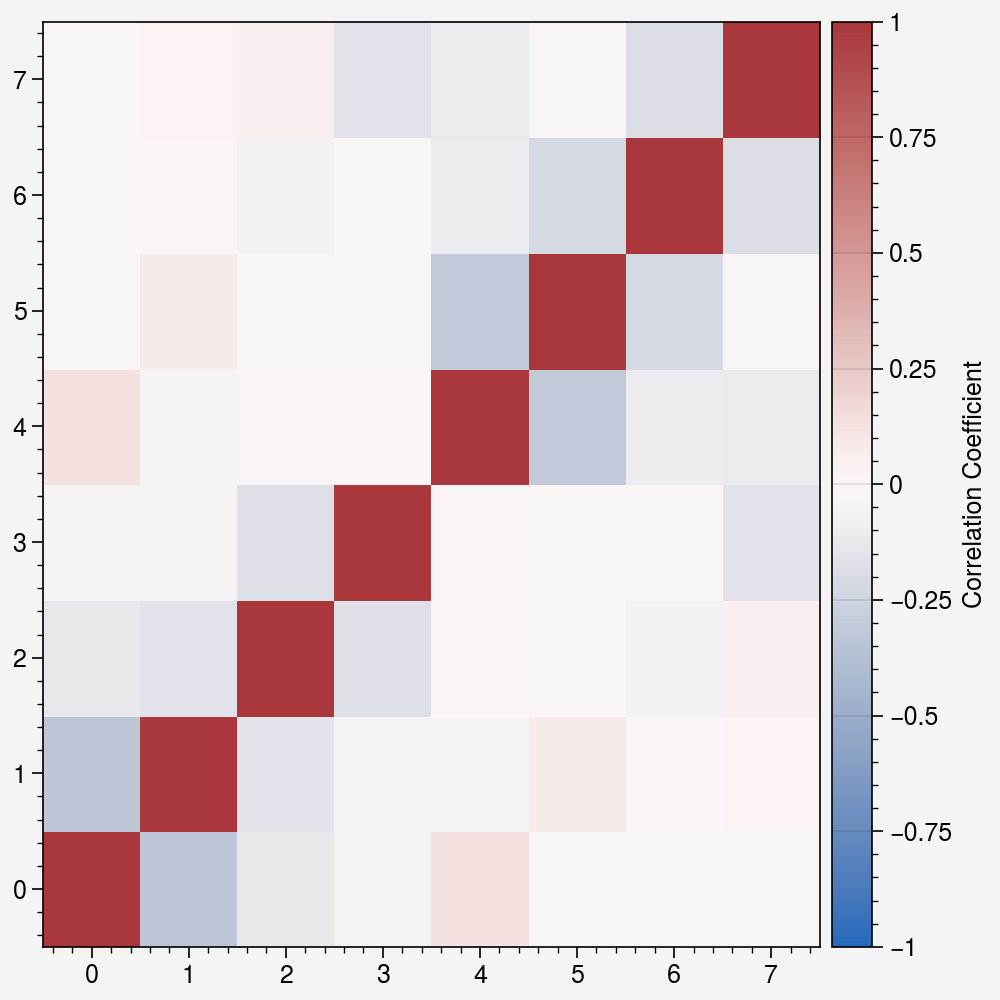

In [40]:
mdz = np.concatenate([mvals, dzvals], axis=1)

corr = np.corrcoef(mdz.T)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)

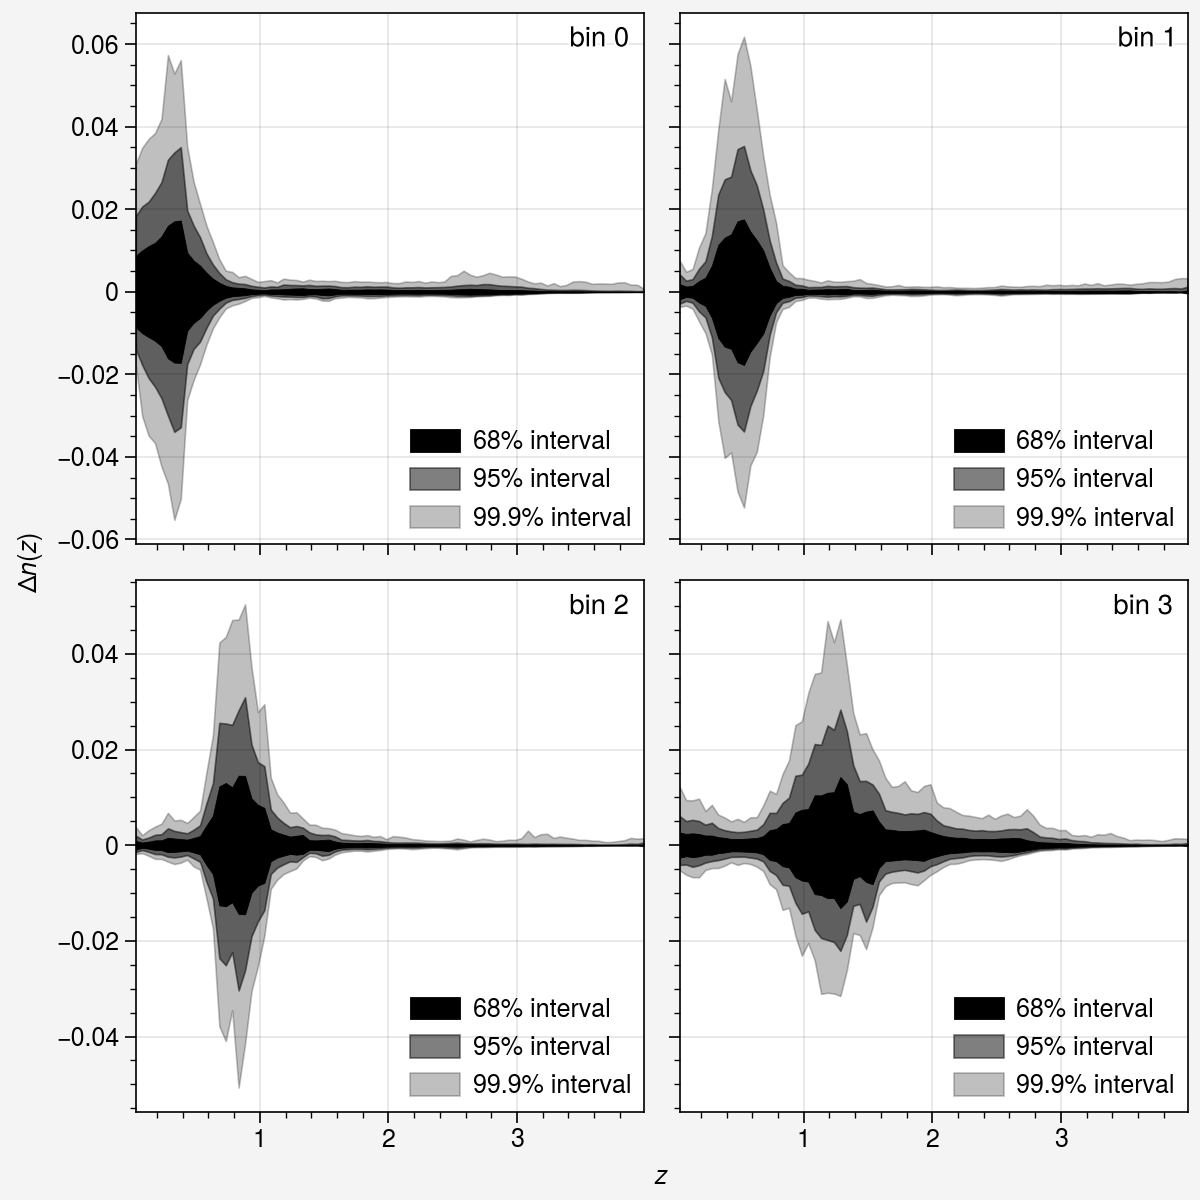

In [41]:
from des_y6_imsim_analysis.utils import GMODEL_COSMOS_Z

fig, axs = uplt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 6),
)

rng = np.random.default_rng(42)
n_sample = 100

bind = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]

        dnz = finalnzs[:, bind, :] - np.mean(finalnzs[:, bind, :], axis=0, keepdims=True)

        for pval, alpha in zip([68, 95, 99.9], [1.0, 0.5, 0.25]):
            uval = 100 - (100 - pval) / 2
            dval = (100 - pval) / 2

            dnz_up = np.percentile(dnz[:, :], uval, axis=0)
            dnz_down = np.percentile(dnz[:, :], dval, axis=0)
            ax.fill_between(
                GMODEL_COSMOS_Z[1:-1],
                dnz_down,
                dnz_up,
                color="k",
                alpha=alpha,
                label=f"{pval}% interval",
            )

        ax.format(
            xlabel=r"$z$",
            ylabel=r"$\Delta n(z)$",
            abc=[f"${{\\rm  bin}}\\ {_bind}$" for _bind in range(4)],
            abcloc="ur",
        )
        ax.legend(
            loc="lr",
            frameon=False,
            ncols=1
        )

        bind += 1